In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=1.5)
from tqdm import tqdm
from scipy.optimize import minimize
from src.QubitClass import Two_qubit

# Two Qubits VQE

This code defines the Hamiltonian for a two-qubit system, calculates the eigenvalues and eigenvectors of this Hamiltonian for various values of the parameter $\lambda$, traces out one of the qubits from the system, and then calculates and plots the entropy of the resulting single-qubit states, along with the energy eigenvalues.

## VQE using a standard eigen vaule solver

We starts by defining some key matrices used to define the Hamiltonian and for operations on the states.

In [87]:
# Define the constants
SIGMA_X = np.array([[0, 1], [1, 0]])
SIGMA_Z = np.array([[1, 0], [0, -1]])
AB0 = np.array([1, 0])
AB1 = np.array([0, 1])
I = np.eye(2)

Then we constructs the Hamiltonian matrix of the system. It is a 4x4 matrix representing a two-qubit system with both interacting and non-interacting parts. The interacting part is weighted by the $\lambda$ parameter.

In [88]:
# Set up a Hamiltonian

def Hamiltonian(lmb):  
    """
    Returns a Hamiltonian matrix for given parameters.

    Parameters
    ----------
    lmb : float
        Lambda parameter of the Hamiltonian.

    Returns
    -------
    numpy array
        The Hamiltonian matrix.
    """   

    Hx = 2.0 
    Hz = 3.0
    
    H0 = [0.0, 2.5, 6.5, 7.0] #Energies non interacting
    
    HI = Hz*np.kron(SIGMA_Z, SIGMA_Z) + Hx*np.kron(SIGMA_X, SIGMA_X)
    H0 = np.diag(H0)
    H = H0 + lmb*HI
    
    return H

Now we make a trace out function that takes in a two-qubit state and traces out one of the qubits, resulting in a single-qubit state. It does this by constructing the density matrix for the state and then taking the partial trace over the specified qubit.

In [89]:
def trace_out(state, index):
    """
    Traces out a qubit in a two-qubit state, effectively reducing the state to that of a single qubit.

    Parameters
    ----------
    state : numpy array
        The state of the two-qubit system.
    index : int
        Index of the qubit to be traced out (0 or 1).

    Returns
    -------
    numpy array
        The reduced state after tracing out the specified qubit.
    """

    density = np.outer(state, np.conj(state))
    
    if index == 0:
        p0 = np.kron(AB0, I)
        p1 = np.kron(AB1, I)
    
    elif index == 1:
        p0 = np.kron(I, AB0)
        p1 = np.kron(I, AB1)
    
    return p0.conj() @ density @ p0.T + p1.conj() @ density @ p1.T # need to take conj() on first and .T on second since np.arrays are 

Then we calculate the eigenvalues and eigenvectors of the Hamiltonian for a range of $\lambda$ values, stores the sorted eigenvalues, and calculates the entropy of the single-qubit state resulting from tracing out one qubit from each eigenvector. The entropy calculation uses the Von Neumann entropy.

In [90]:
lmbvalues_ana = np.arange(0, 1, 0.01)
eigvals_ana = np.zeros((len(lmbvalues_ana), 4))

entropy = np.zeros((len(lmbvalues_ana), 4))

for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)

    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()

    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

    for i in range(4):
        sub_density = trace_out(eigvecs[:, i], 0) # trace out qubit 0 from the ground state
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed() # remove zeros to avoid log(0)

        entropy[index, i] = -np.sum(lmb_density*np.log2(lmb_density)) # calculate the von Neumann entropy

Lastly, we plot the energy eigenvalues and the entropy of the single-qubit states against $\lambda$

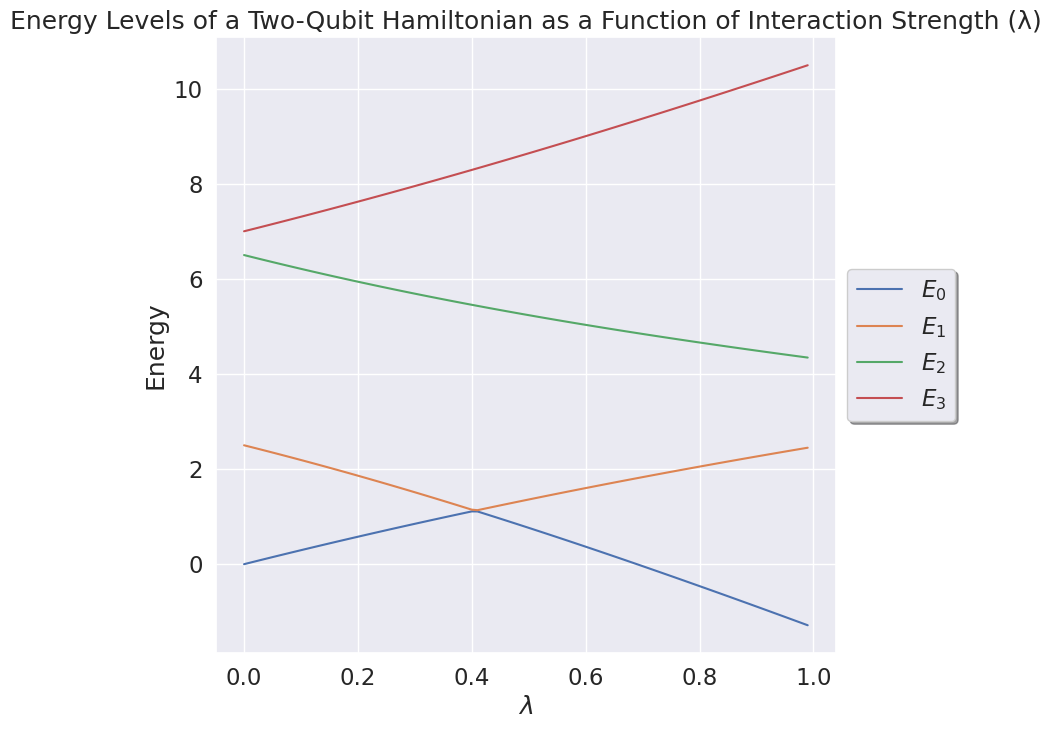

In [91]:
# Plot the results

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

for i in range(4):
    axs.plot(lmbvalues_ana, eigvals_ana[:, i], label=f'$E_{i}$')

axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title('Energy Levels of a Two-Qubit Hamiltonian as a Function of Interaction Strength (λ)')
plt.show()

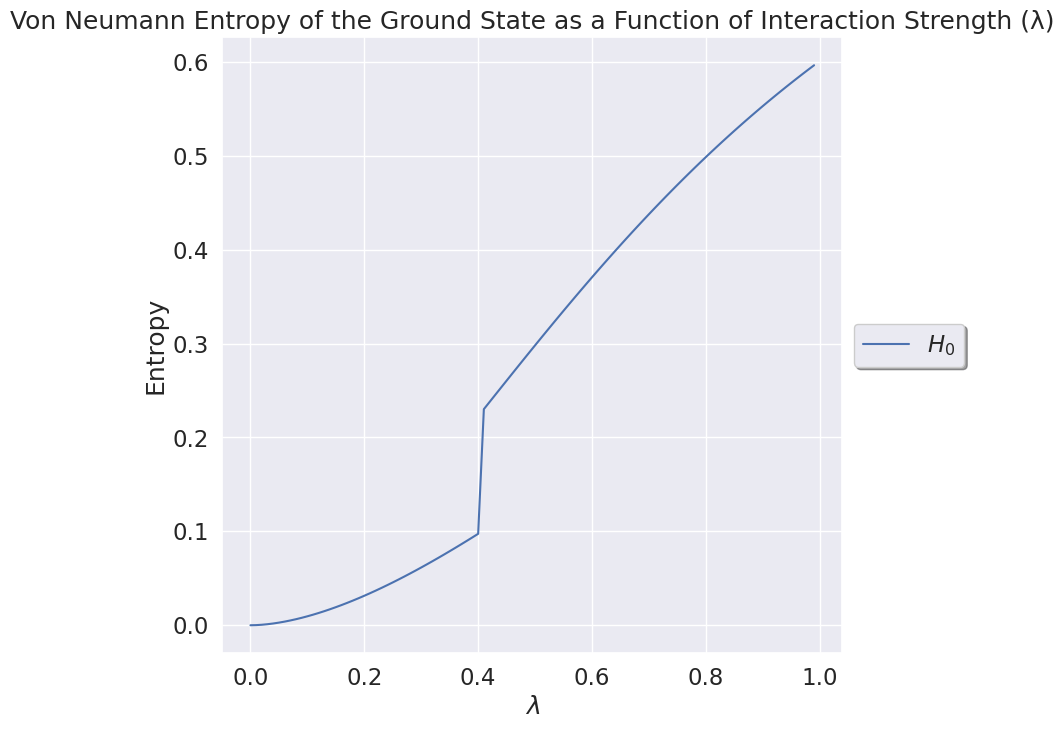

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

for i in range(1):
    axs.plot(lmbvalues_ana, entropy[:, i], label=f'$H_{i}$')

axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Entropy')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title('Von Neumann Entropy of the Ground State as a Function of Interaction Strength (λ)')
plt.show()

The plots gives a insight into how the energy and entropy of the system evolve with the parameter $\lambda$.

## Hamiltonian in terms of Pauli matrices

Here the code rewritten in terms of Pauli matrices.

First we prepare the state of two qubits based on the given rotation angles.

In [93]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

Then we computes the expectation value of the energy for a given state, Hamiltonian, and number of measurements. 

In [94]:
def get_energy(angles, lmb, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_cnot10() # rotate measurement basis
    measure_zz = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_zz, measure_xx])
    constants = np.array([B, C, D + lmb*Hz, lmb*Hx])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = A + np.sum(constants * exp_vals) / number_shots
    return exp_val

Next, we perform energy minimization by adjusting the angles for state preparation.

In [95]:
def minimize_energy(lmb, number_shots, angles_0, learning_rate, max_epochs):
    angles = angles_0 
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, lmb, number_shots)
    while (epoch < max_epochs) and (delta_energy > 1e-5):
        grad = np.zeros_like(angles)
        for idx in range(angles.shape[0]):
            angles_temp = angles.copy()
            angles_temp[idx] += np.pi/2 
            E_plus = get_energy(angles_temp, lmb, number_shots)
            angles_temp[idx] -= np.pi 
            E_minus = get_energy(angles_temp, lmb, number_shots)
            grad[idx] = (E_plus - E_minus)/2
        angles -= learning_rate*grad 
        new_energy = get_energy(angles, lmb, number_shots)
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy

Then we perform energy minimization for each lambda value

In [96]:
number_shots_search = 1000
learning_rate = 0.3
max_epochs = 5000
lmbvalues = np.linspace(0.0, 1.0, 11)
min_energy = np.zeros(len(lmbvalues))
epochs = np.zeros(len(lmbvalues))
for index, lmb in enumerate((lmbvalues)):
    angles0 = np.random.uniform(low = 0, high = np.pi, size = 4)
    angles, epochs[index], converged, min_energy[index], delta_energy = minimize_energy(lmb, number_shots_search, angles0, learning_rate, max_epochs)
    print(f'Lambda = {lmb}, Energy = {min_energy[index]}, Epochs = {epochs[index]}, Converged = {converged}, Delta Energy = {delta_energy}')

Lambda = 0.0, Energy = 0.0015000000000000568, Epochs = 10.0, Converged = True, Delta Energy = 0.0
Lambda = 0.1, Energy = 0.29380000000000006, Epochs = 430.0, Converged = True, Delta Energy = 0.0
Lambda = 0.2, Energy = 0.5846, Epochs = 310.0, Converged = True, Delta Energy = 0.0
Lambda = 0.30000000000000004, Energy = 0.8700000000000001, Epochs = 156.0, Converged = True, Delta Energy = 0.0
Lambda = 0.4, Energy = 1.1013000000000002, Epochs = 640.0, Converged = True, Delta Energy = 0.0
Lambda = 0.5, Energy = 0.7749999999999999, Epochs = 245.0, Converged = True, Delta Energy = 0.0
Lambda = 0.6000000000000001, Energy = 0.3940999999999999, Epochs = 48.0, Converged = True, Delta Energy = 0.0
Lambda = 0.7000000000000001, Energy = -0.04070000000000018, Epochs = 83.0, Converged = True, Delta Energy = 0.0
Lambda = 0.8, Energy = -0.3467000000000011, Epochs = 5000.0, Converged = False, Delta Energy = 0.11269999999999936
Lambda = 0.9, Energy = -0.9152000000000005, Epochs = 552.0, Converged = True, De

In [97]:
number_shots = 10_000
lmbvalues = np.linspace(0.0, 1.0, 50)
min_energy_scipy = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


Lastly, we create a plot showing the energy values obtained from the variational quantum eigensolver (VQE) approach ('min_energy') and the SciPy optimization ('min_energy_scipy'). It also includes the energy eigenvalues of the system. 

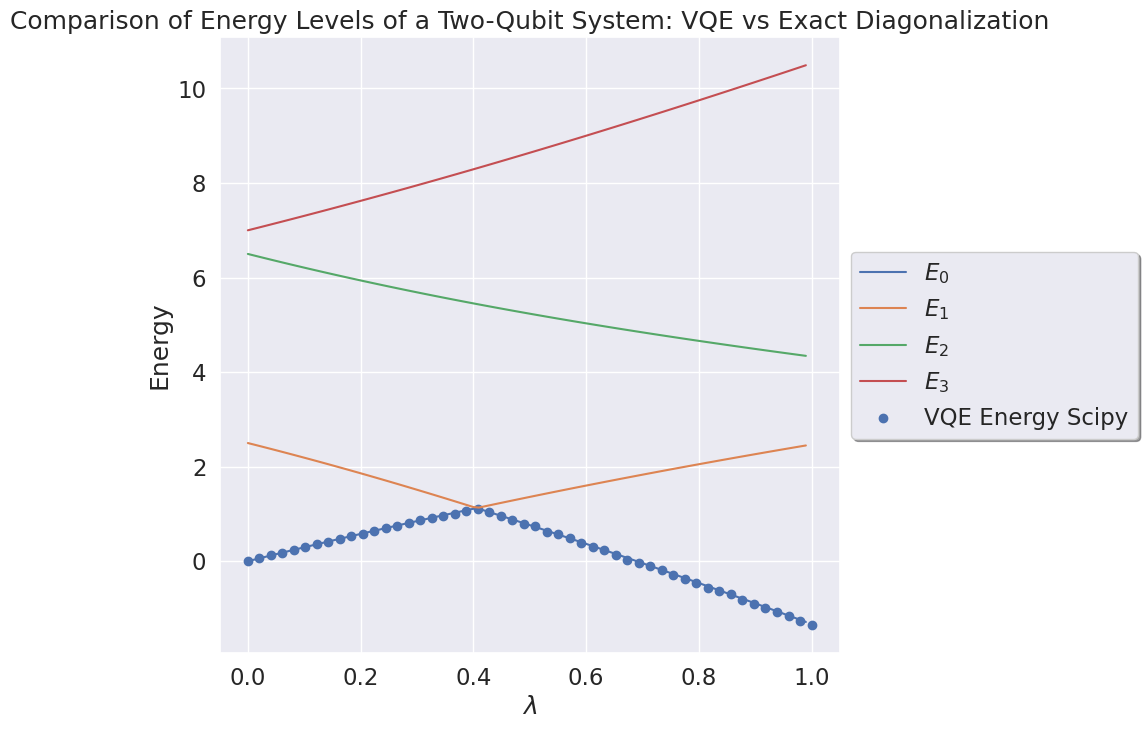

In [98]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(4):
    axs.plot(lmbvalues_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$\lambda$')
# axs.scatter(lmbvalues, min_energy, label='VQE Energy GD', marker='o')
axs.scatter(lmbvalues, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel('Energy')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title('Comparison of Energy Levels of a Two-Qubit System: VQE vs Exact Diagonalization')
plt.show()